* PAPER - PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation - [[PDF](https://arxiv.org/pdf/1612.00593.pdf)]
* Summary - [Blog](https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a)

# 준비

## 라이브러리

In [1]:
import os
import glob

import trimesh

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## 데이터
- .off 확장자는 mesh 데이터이다. 이를 읽으려면 Lib.trimesh 가 필요하다

In [3]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [89]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

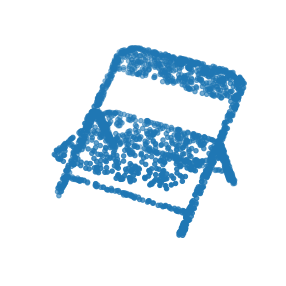

In [5]:
points = mesh.sample(2048) # 2048개의 랜덤 샘플 점을 찍어서 3D 데이터를 표현

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [61]:
"hi\\hi".split("\\")

['hi', 'hi']

In [88]:
class_folders = glob.glob(os.path.join(DATA_DIR,"[!R]*"))
for class_folder in class_folders:
    class_name = class_folder.split("\\")[-1]
    print(f'class \'{class_name}\' folder path : {class_folder}')
    in_folder = glob.glob(class_folder+"/*")
    for files_path in in_folder:
        files_name = files_path.split("\\")[-1]
        count = glob.glob(files_path+"/*")
        print("\t\t\t\tㄴ",files_name, ", image counts : ", len(count))

class 'bathtub' folder path : C:\Users\user\.keras\datasets\ModelNet10\bathtub
				ㄴ test , image counts :  50
				ㄴ train , image counts :  106
class 'bed' folder path : C:\Users\user\.keras\datasets\ModelNet10\bed
				ㄴ test , image counts :  100
				ㄴ train , image counts :  515
class 'chair' folder path : C:\Users\user\.keras\datasets\ModelNet10\chair
				ㄴ test , image counts :  100
				ㄴ train , image counts :  889
class 'desk' folder path : C:\Users\user\.keras\datasets\ModelNet10\desk
				ㄴ test , image counts :  86
				ㄴ train , image counts :  200
class 'dresser' folder path : C:\Users\user\.keras\datasets\ModelNet10\dresser
				ㄴ test , image counts :  86
				ㄴ train , image counts :  200
class 'monitor' folder path : C:\Users\user\.keras\datasets\ModelNet10\monitor
				ㄴ test , image counts :  100
				ㄴ train , image counts :  465
class 'night_stand' folder path : C:\Users\user\.keras\datasets\ModelNet10\night_stand
				ㄴ test , image counts :  86
				ㄴ train , image counts

In [23]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!R]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [24]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: bathtub
processing class: bed
processing class: chair
processing class: desk
processing class: dresser
processing class: monitor
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


## 증강

In [27]:
def augment(points, label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)# jitter points - NOISE 생성
    points = tf.random.shuffle(points)# shuffle points
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

# 모델

`affine` : 아핀 공간은 유클리드 공간의 아핀 기하학적 성질들을 일반화해서 만들어지는 구조이다.
아핀 공간에서는 점에서 점을 빼서 벡터를 얻거나 점에 벡터를 더해 다른 점을 얻을 수는 있지만 원점이 없으므로 점과 점을 더할 수는 없다.

`canonical representation` : 수학과 컴퓨터 과학에서, 수학적 대상의 표준 형식, 또는 표준형, 표준꼴, 정규형(canonical form, standard form, normal form)은 그 대상을 표현하는 표준적인 방법이다. 이는 또한 자연적인 (표준적인) 방법으로 정의한 미분 형식을 의미하기도 한다. 표준 형식을 찾는 방법은 표준화 또는 정규화(canonicalization)라고 한다.

`orthogonal matrix` : 직교 행렬은 행벡터와 열벡터가 유클리드 공간의 정규 직교 기저를 이루는 실수 행렬이다.

## Conv

In [64]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("leaky_relu")(x)

## FC

In [65]:
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("leaky_relu")(x)

## OrthogonalRegularizer

In [66]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

## Tnet

In [67]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten()) # cls 토큰
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

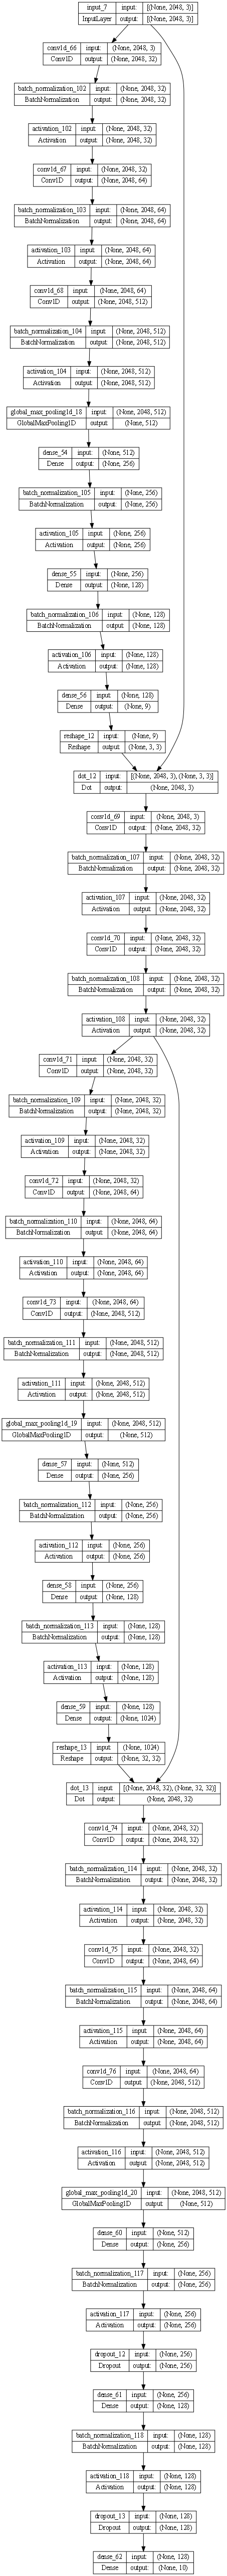

In [68]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
tf.keras.utils.plot_model(model, dpi=70, show_shapes=True)

# 훈련

## relu, Adam

In [45]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=10, restore_best_weights=True)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=[es])

Epoch 1/20
125/125 [==============================] - 22s 150ms/step - loss: 3.5290 - sparse_categorical_accuracy: 0.2894 - val_loss: 9424231424.0000 - val_sparse_categorical_accuracy: 0.2070
Epoch 2/20
125/125 [==============================] - 18s 147ms/step - loss: 3.0228 - sparse_categorical_accuracy: 0.4022 - val_loss: 12.7752 - val_sparse_categorical_accuracy: 0.1178
Epoch 3/20
125/125 [==============================] - 18s 147ms/step - loss: 2.7707 - sparse_categorical_accuracy: 0.4500 - val_loss: 523462292537344.0000 - val_sparse_categorical_accuracy: 0.4383
Epoch 4/20
125/125 [==============================] - 19s 148ms/step - loss: 2.6803 - sparse_categorical_accuracy: 0.5081 - val_loss: 523279924199424.0000 - val_sparse_categorical_accuracy: 0.4659
Epoch 5/20
125/125 [==============================] - 18s 148ms/step - loss: 2.4850 - sparse_categorical_accuracy: 0.5695 - val_loss: 11095047667712.0000 - val_sparse_categorical_accuracy: 0.5033
Epoch 6/20
125/125 [==============

1/1 [==============================] - 0s 15ms/step


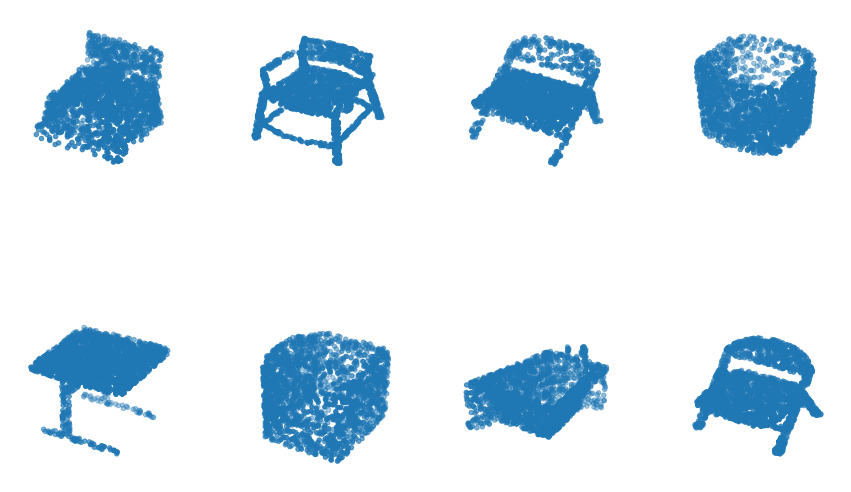

In [61]:
loss, acc = model.evaluate(test_dataset)
print(f"Model evaluate : [acc = {acc}], [loss = {loss}]", )

data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_axis_off()
plt.show()

## leaky_relu, AdamW

In [70]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=10, restore_best_weights=True)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001,weight_decay=0.0001),
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=[es])

Epoch 1/20
125/125 [==============================] - 23s 153ms/step - loss: 3.7125 - sparse_categorical_accuracy: 0.2924 - val_loss: 538370560.0000 - val_sparse_categorical_accuracy: 0.1178
Epoch 2/20
125/125 [==============================] - 19s 150ms/step - loss: 3.2422 - sparse_categorical_accuracy: 0.3738 - val_loss: 4209429532639232.0000 - val_sparse_categorical_accuracy: 0.3711
Epoch 3/20
125/125 [==============================] - 19s 150ms/step - loss: 2.7929 - sparse_categorical_accuracy: 0.4803 - val_loss: 885644984320.0000 - val_sparse_categorical_accuracy: 0.3678
Epoch 4/20
125/125 [==============================] - 19s 151ms/step - loss: 2.6054 - sparse_categorical_accuracy: 0.5457 - val_loss: 469429977088.0000 - val_sparse_categorical_accuracy: 0.4427
Epoch 5/20
125/125 [==============================] - 19s 152ms/step - loss: 2.4543 - sparse_categorical_accuracy: 0.5765 - val_loss: 133927579525813633024.0000 - val_sparse_categorical_accuracy: 0.5374
Epoch 6/20
125/125 [

29/29 [==============================] - 1s 39ms/step - loss: 3022798979072.0000 - sparse_categorical_accuracy: 0.7830
Model evaluate : [acc = 0.7830396294593811], [loss = 3022798979072.0]
1/1 [==============================] - 0s 15ms/step


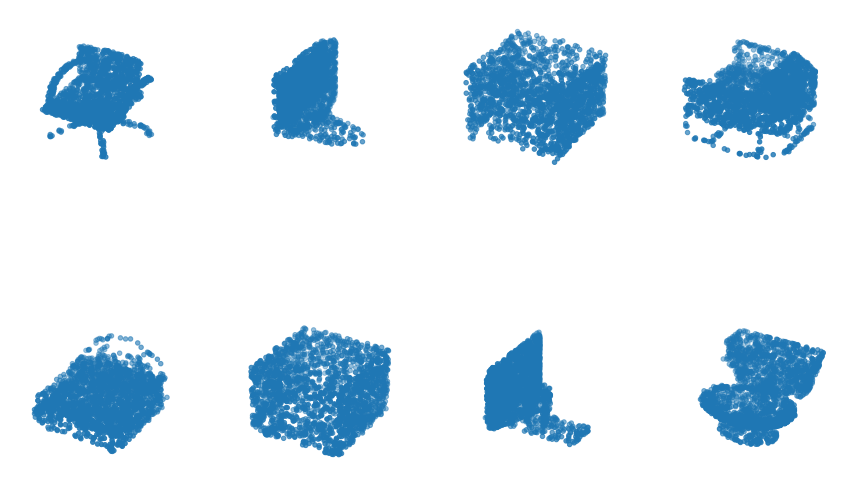

In [76]:
loss, acc = model.evaluate(test_dataset)
print(f"Model evaluate : [acc = {acc}], [loss = {loss}]", )
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)

preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_axis_off()
plt.show()